# Tutorial - Keane and Wolpin (1994) - Simulation

Keane and Wolpin (1994) generate three different Monte Carlo samples. We study their first parameterization in more detail now. We label the two occupations as Occupation A and Occupation B.

We first plot the returns to experience while holding education constant at the initial ten years. Occupation B is more skill intensive in the sense that own experience has higher return than is the case for Occupation A. There is some general skill learned in Occupation A which is transferable to Occupation B. However, work experience is occupation-specific in Occupation B.

In [1]:
%matplotlib agg
import matplotlib.pyplot as plt
import numpy as np
import warnings

from mpl_toolkits.mplot3d import Axes3D

import respy as rp

warnings.filterwarnings("ignore")

In [2]:
plt.style.use("../_static/respy.mplstyle")

In [3]:
# Load example model and convert parameter and options to model attributes.
params, options, _ = rp.get_example_model("kw_94_one")

In [4]:
ret_schooling_occ_a = params.loc[("wage_a", "exp_edu"), "para"][0]
ret_schooling_occ_b = params.loc[("wage_b", "exp_edu"), "para"][0]

ret_exp_a_occ_a = params.loc[("wage_a", "exp_a"), "para"][0]
ret_exp_a_sq_occ_a = params.loc[("wage_a", "exp_a_square"), "para"][0]
ret_exp_b_occ_a = params.loc[("wage_a", "exp_b"), "para"][0]
ret_exp_b_sq_occ_a = params.loc[("wage_a", "exp_b_square"), "para"][0]
skill_price_occ_a = params.loc[("wage_a", "constant"), "para"][0]

ret_exp_a_occ_b = params.loc[("wage_b", "exp_a"), "para"][0]
ret_exp_a_sq_occ_b = params.loc[("wage_b", "exp_a_square"), "para"][0]
ret_exp_b_occ_b = params.loc[("wage_b", "exp_b"), "para"][0]
ret_exp_b_sq_occ_b = params.loc[("wage_b", "exp_b_square"), "para"][0]
skill_price_occ_b = params.loc[("wage_b", "constant"), "para"][0]

In [5]:
x, y = np.meshgrid(range(0, 20), range(0, 20))

z_a = np.exp(
    skill_price_occ_a + ret_schooling_occ_a * 10
    + ret_exp_a_occ_a * x + ret_exp_a_sq_occ_a * x ** 2 / 100
    + ret_exp_b_occ_a * y + ret_exp_b_sq_occ_a * y ** 2 / 100
)

z_b = np.exp(
    skill_price_occ_b + ret_schooling_occ_b * 10
    + ret_exp_a_occ_b * x + ret_exp_a_sq_occ_b * x ** 2 / 100
    + ret_exp_b_occ_b * y + ret_exp_b_sq_occ_b * y ** 2 / 100
)

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

ax1.plot_surface(x, y, z_a / 1000, color="C2")
ax2.plot_surface(x, y, z_b / 1000, color="C3")

for ax in [ax1, ax2]:
    ax.set_xticks(range(0, 21, 5))
    ax.set_yticks(range(0, 21, 5))
    ax.set_zticks(range(10, 36, 5))
    ax.set_zticklabels(range(10, 36, 5))
    ax.set_zlim(10, 35)
    ax.invert_xaxis()
    ax.set_xlabel("Experience A", labelpad=15)
    ax.set_ylabel("Experience B", labelpad=15)
    ax.set_proj_type('ortho')
    ax.set_zlabel("Wages in (\$1,000)", labelpad=15, rotation="vertical")
    
ax1.set_title("(a)", y=-0.15)
ax2.set_title("(b)", y=-0.15);

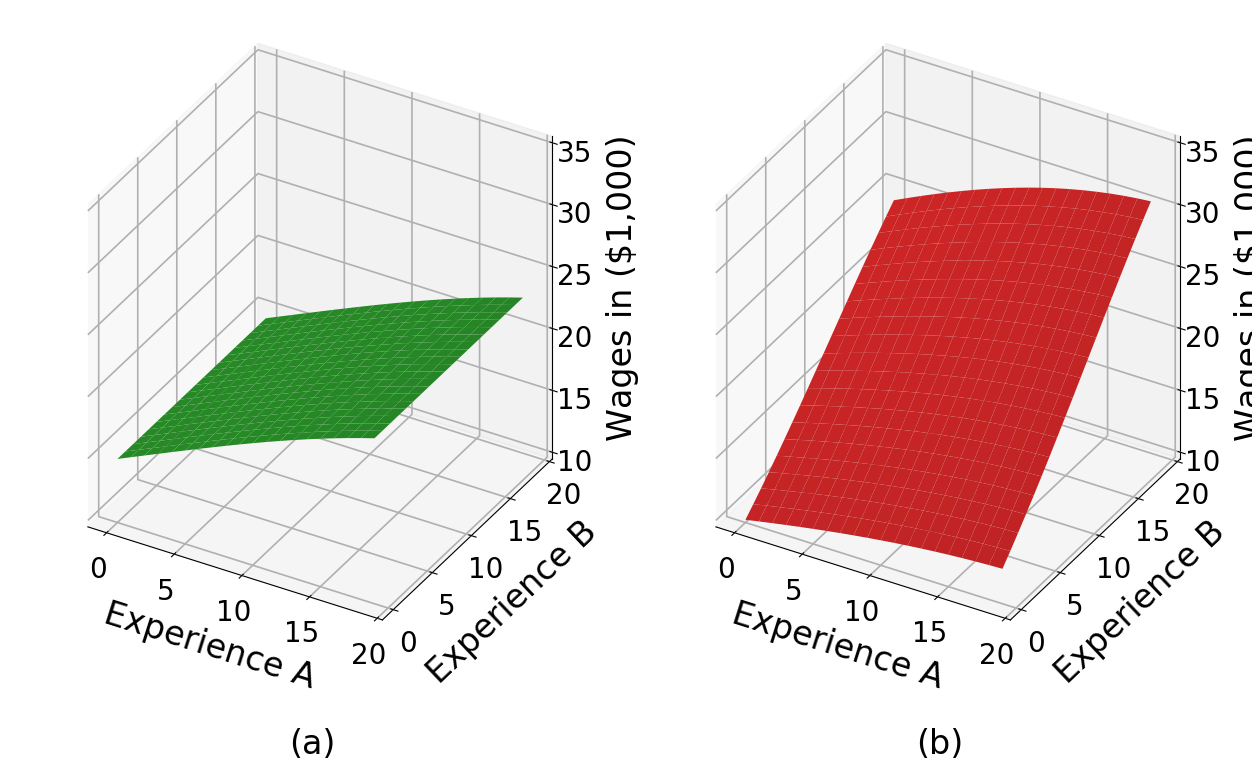

In [7]:
fig

The next figure shows that the returns to schooling are larger in Occupation B. While its initial wage is lower, it does increase faster with schooling compared to Occupation A. The graphs are generated by holding experience in both sectors constant at five years.

In [8]:
years_schooling = np.arange(10, 21)

wage_a = np.exp(
    skill_price_occ_a + ret_schooling_occ_a * years_schooling
    + ret_exp_a_occ_a * 5 + ret_exp_a_sq_occ_a * 5 ** 2 / 100
    + ret_exp_b_occ_a * 5 + ret_exp_b_sq_occ_a * 5 ** 2 / 100
)

wage_b = np.exp(
    skill_price_occ_b + ret_schooling_occ_b * years_schooling
    + ret_exp_a_occ_b * 5 + ret_exp_a_sq_occ_b * 5 ** 2 / 100
    + ret_exp_b_occ_b * 5 + ret_exp_b_sq_occ_b * 5 ** 2 / 100
)

fig, ax = plt.subplots()

ax.plot(years_schooling, wage_a / 1000, color="C2", label="Occupation A")
ax.plot(years_schooling, wage_b / 1000, color="C3", label="Occupation B")

ax.set_xlim(10, 20)
ax.set_ylim(14, 30)
ax.set_yticks(range(16, 31, 2))

ax.set_xlabel("Years of Schooling")
ax.set_ylabel("Wages (in \$1,000)")

ax.legend();

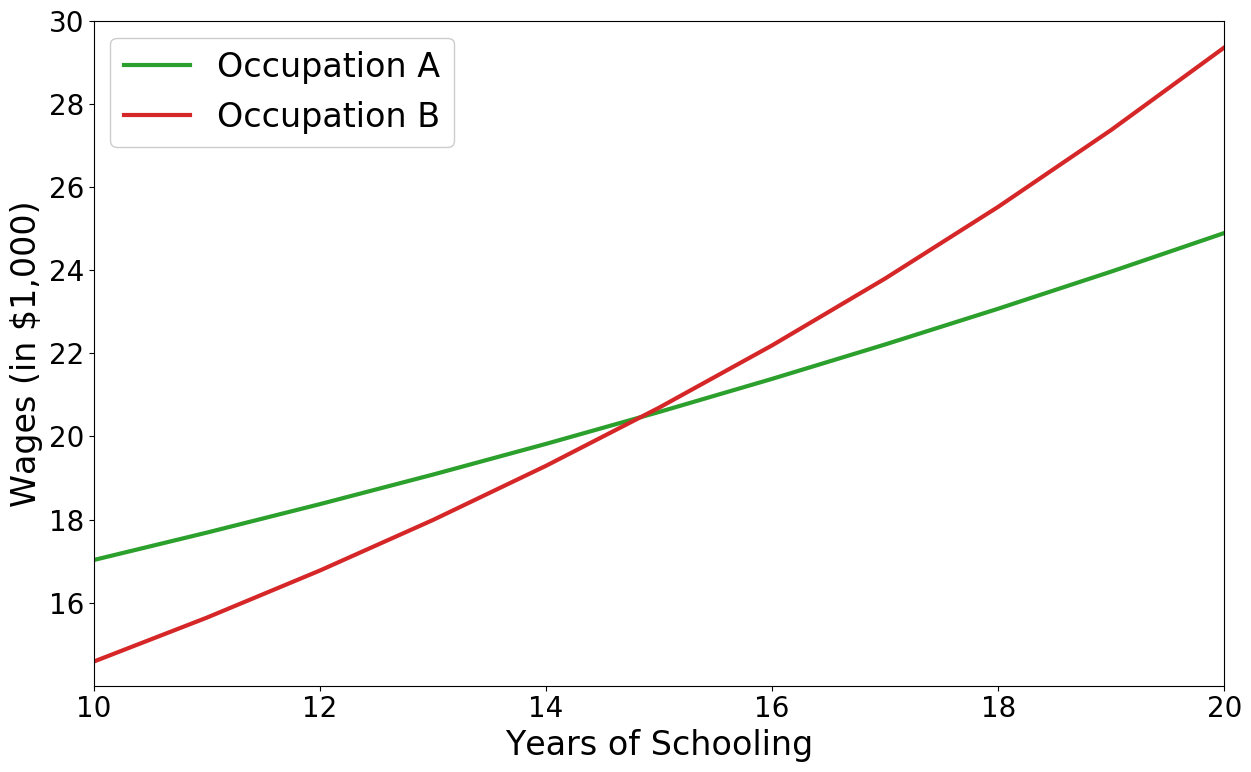

In [9]:
fig

Simulating a sample of 1,000 agents from the model allows us to study how these features interact in determining agent decisions over their life cycle. Note that all agents start out identically, different choices are simply the cumulative effects of different shocks. Initially, 50% of agents increase their level of schooling but the share of agents enrolled in school declines sharply over time. The share working in Occupation A hovers around 40% at first, but then declines to 21%. Occupation B continuously gains in popularity, initially only 11% work in Occupation B but its share increases to about 77%. Around 1.5% stay at home each period. We visualize this choice pattern in detail below.

In [10]:
_, df = rp.simulate(params, options)

In [11]:
fig, ax = plt.subplots()

shares = df.groupby("Period").Choice.value_counts().unstack()[["home", "edu", "a", "b"]].div(1000)

shares.plot.bar(stacked=True, ax=ax, width=0.8)

ax.legend(
    labels=["Home", "School", "A", "B"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=4
)

ax.set_ylim(0, 1)

ax.set_xticks(range(0, 40, 5))
ax.set_xticklabels(range(0, 40, 5), rotation="horizontal")

ax.set_ylabel("Share of population");

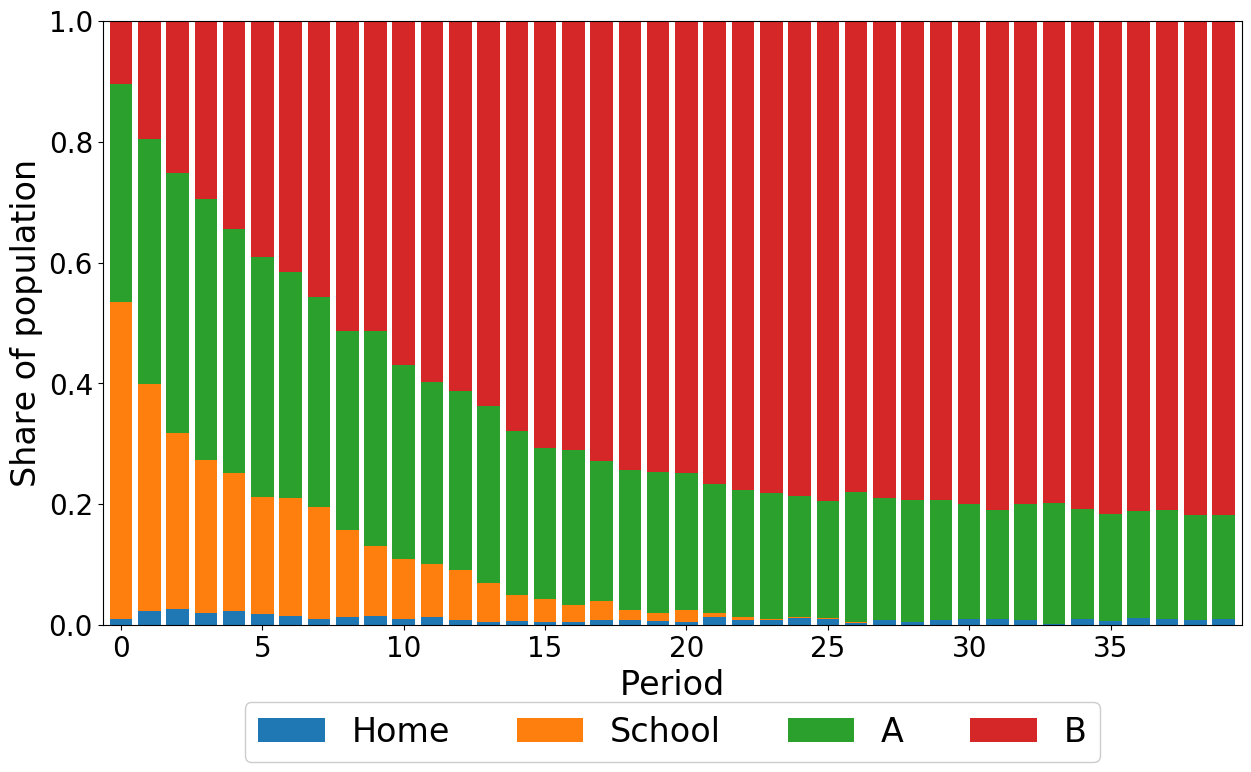

In [12]:
fig

We start out with the large majority of agents working in Occupation A. Eventually, however, most agents end up working in Occupation B. As the returns to education are higher for Occupation B and previous work experience is transferable, Occupation B gets more and more attractive as agents increase their level of schooling and gain experience in the labor market.

For the next graph, we assume that the cost of education in high school and college
increase from 4,000 to 10,000 per year. Again, we simulate a sample of 1,000 agents and look at
the distribution of choices over the life cycle. As the cost of education increases,
fewer people re-enroll into high school or college. This drives down returns in
occupation B which is still the choice of the majority, but now the stable share is 65\%
instead of 80\%. Furthermore, more people stay at home as education is too costly to
obtain and thus they never earn wages high enough to surpass the returns from home
production.

In [13]:
params.loc[("nonpec_edu", "is_return_not_high_school"), "para"] = -10000
params.loc[("nonpec_edu", "is_return_high_school"), "para"] = -10000

_, df = rp.simulate(params, options)

In [14]:
fig, ax = plt.subplots()

shares = df.groupby("Period").Choice.value_counts().unstack()[["home", "edu", "a", "b"]].div(1000)

shares.plot.bar(stacked=True, ax=ax, width=0.8)

ax.legend(
    labels=["Home", "School", "A", "B"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=4
)

ax.set_ylim(0, 1)

ax.set_xticks(range(0, 40, 5))
ax.set_xticklabels(range(0, 40, 5), rotation="horizontal")

ax.set_ylabel("Share of population");

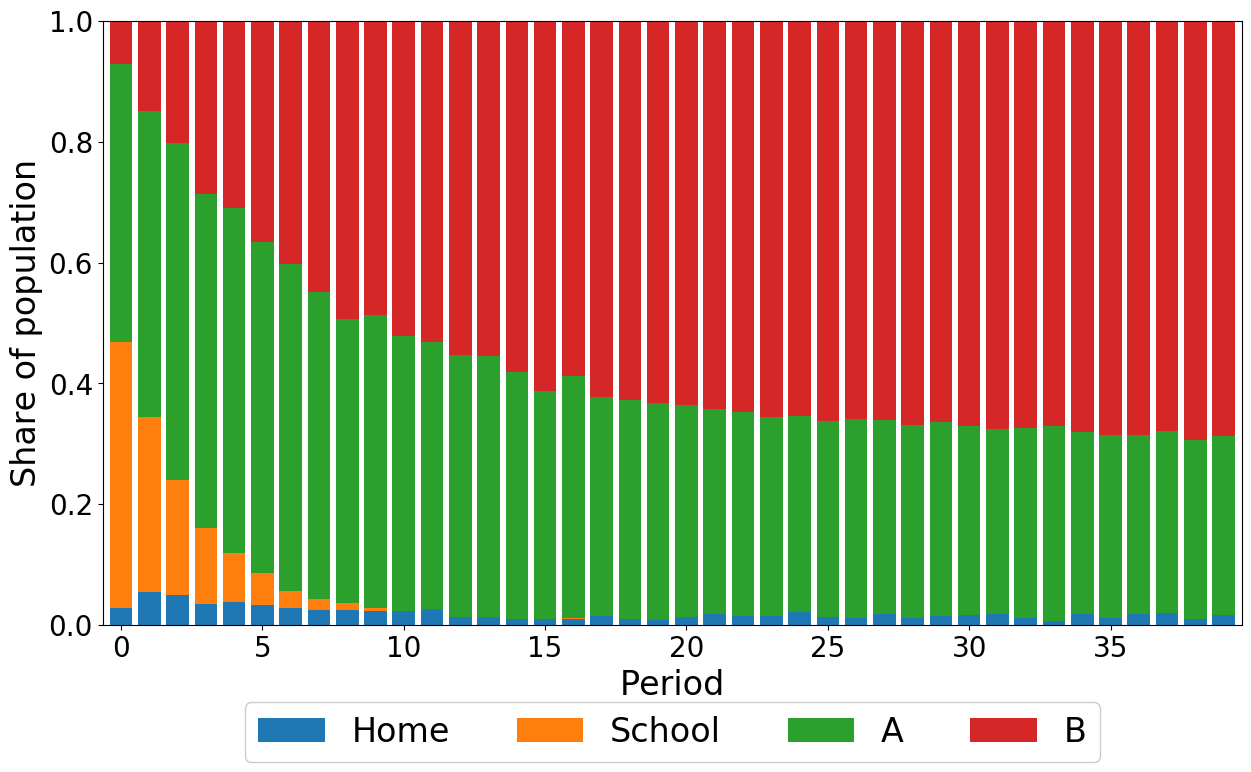

In [15]:
fig